# Working with Bag of Words

-------------------------------------

**在此示例中，我们将下载并预处理 SMS Spam 文本数据。 然后，我们将使用 独热编码（one-hot-encoding）和 逻辑回归 。**

**我们将使用这些独热矢量（one-hot-vectors）进行逻辑回归来预测文本是否为垃圾邮件（正常邮件标签：ham，垃圾邮件标签：spam）**

**首先导入必要的库**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import string
from tensorflow.contrib import learn
from tensorflow.python.framework import ops
ops.reset_default_graph()

**打开一个会话（session）**

In [2]:
# Start a graph session
sess = tf.Session()

**检查数据是否已经下载，否则下载数据（作者给出的文件已经不存在了，现在已经变成SMSSpamCollection，所以我进行了修改）**

**数据集链接：http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip **

In [3]:
# 数据集文件位置：./smsspamcollection/SMSSpamCollection
save_file_name = os.path.join('smsspamcollection','SMSSpamCollection')

# Create directory if it doesn't exist
if not os.path.exists('smsspamcollection'):
    print('Not Found ...')
    os.makedirs('smsspamcollection')

In [4]:
messages = [line.rstrip() for line in open(save_file_name, 'r', encoding='UTF-8')]  # 没有encoding的话报错UnicodeDecodeError
print(len(messages))

5574


In [5]:
for message_no, message in enumerate(messages[:5]):
    print(message_no, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though


**这是一个 TSV 文件（用制表符 tab 分隔），它的第一列是标记“正常信息”（ham）或“垃圾文件”（spam）的标签，第二列是信息本身**

In [6]:
text_label = []
text_data = []
for message in messages:
    text = message.split('\t')
    text_label.append(text[0])
    text_data.append(text[1])
print(text_label[:3])
print(len(text_label))
print(text_data[:3])
print(len(text_data))

['ham', 'ham', 'spam']
5574
['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'Ok lar... Joking wif u oni...', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]
5574


**对数据进行预处理，例如删除标点和数字等等.**

In [7]:
# Relabel 'spam' as 1, 'ham' as 0
target = [1 if x=='spam' else 0 for x in text_label]

# Normalize text

# Lower case
texts = [x.lower() for x in text_data]

# Remove punctuation and numbers
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# Trim extra whitespace
texts = [' '.join(x.split()) for x in texts]

In [8]:
target[:5]

[0, 0, 1, 0, 0]

In [9]:
texts[:5]

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni',
 'free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs',
 'u dun say so early hor u c already then say',
 'nah i dont think he goes to usf he lives around here though']

**To determine a good sentence length to pad/crop at, we plot a histogram of text lengths (in words).**

**为了确定填充/裁剪的良好句子长度，我们绘制文本长度的直方图（以单词表示）。**

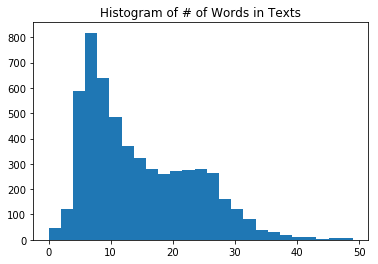

In [10]:
%matplotlib inline
# Plot histogram of text lengths
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 50]
plt.hist(text_lengths, bins=25)
plt.title('Histogram of # of Words in Texts')
plt.show()

**We crop/pad all texts to be 25 words long.  We also will filter out any words that do not appear at least 3 times.**

**我们将所有文本裁剪/填充为25个单词长度。我们还会过滤掉出现少于三次的单词。**

In [11]:
# Choose max text word length at 25
sentence_size = 25
min_word_freq = 3

**TensorFlow 有一个文本处理函数 `VocabularyProcessor()`. 我们使用这个函数来处理文本.**

**tensorflow.contrib.learn.preprocessing.VocabularyProcessor(max_document_length, min_frequency = 0, vocabulary = None, tokenizer_fn = None)**

参数：

max_document_length: 文档的最大长度。如果文本的长度大于最大长度，那么它会被剪切，反之则用0填充

min_frequency: 词频的最小值，出现次数小于最小词频则不会被收录到词表中

vocabulary: CategoricalVocabulary 对象

tokenizer_fn：分词函数

In [12]:
# Setup vocabulary processor
vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, min_frequency=min_word_freq)

# Have to fit transform to get length of unique words.
trans = vocab_processor.transform(texts)
transformed_texts = np.array([x for x in trans])
embedding_size = len(np.unique(transformed_texts))

In [13]:
print(vocab_processor)

In [14]:
print(trans)

<generator object VocabularyProcessor.transform at 0x00000288791A93B8>


In [15]:
print(transformed_texts)

[[   1    2    3 ...,    0    0    0]
 [  21   22   23 ...,    0    0    0]
 [  27   28    8 ...,   44   45   46]
 ..., 
 [8161  332    8 ...,    0    0    0]
 [ 141 2555  224 ...,   32  894   83]
 [3382   69 1250 ...,    0    0    0]]


In [16]:
print(embedding_size)

8165


**为了测试我们的 Logistic Model （预测邮件是spam还是ham），将数据集分成训练集和测试集。**

In [17]:
# Split up data set into train/test
train_indices = np.random.choice(len(texts), round(len(texts)*0.8), replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

**For one-hot-encoding, we setup an identity matrix for the TensorFlow embedding lookup.**

**We also create the variables and placeholders for the logistic regression we will perform.**

In [18]:
# Setup Index Matrix for one-hot-encoding
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))

# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Initialize placeholders
x_data = tf.placeholder(shape=[sentence_size], dtype=tf.int32)
y_target = tf.placeholder(shape=[1, 1], dtype=tf.float32)

**Next, we create the text-word embedding lookup with the prior identity matrix.**

**Our logistic regression will use the counts of the words as the input.  The counts are created by summing the embedding output across the rows.**

**Then we declare the logistic regression operations. Note that we do not wrap the logistic operations in the sigmoid function because this will be done in the loss function later on.**

In [19]:
# Text-Vocab Embedding
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
x_col_sums = tf.reduce_sum(x_embed, 0)

# Declare model operations
x_col_sums_2D = tf.expand_dims(x_col_sums, 0)
model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)

**Now we declare our loss function (which has the sigmoid built in), prediction operations, optimizer, and initialize the variables.**

In [20]:
# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Prediction operation
prediction = tf.sigmoid(model_output)

# Declare optimizer
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

# Intitialize Variables
sess.run(tf.global_variables_initializer())

**Now we loop through the iterations and fit the logistic regression on wether or not the text is spam or ham.**

In [21]:
# Start Logistic Regression
print('Starting Training Over {} Sentences.'.format(len(texts_train)))
loss_vec = []
train_acc_all = []
train_acc_avg = []

for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [[target_train[ix]]]
    
    sess.run(train_step, feed_dict={x_data: t, y_target: y_data})
    temp_loss = sess.run(loss, feed_dict={x_data: t, y_target: y_data})
    loss_vec.append(temp_loss)
    
    if (ix+1)%10 == 0:  # 每隔10输出一次loss值
        print('Training Observation #' + str(ix+1) + ': Loss = ' + str(temp_loss))
        
    # Keep trailing average of past 50 observations accuracy
    
    # Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    
    # Get True/False if prediction is accurate
    train_acc_temp = target_train[ix]==np.round(temp_pred)
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:]))

Starting Training Over 4459 Sentences.
Training Observation #10: Loss = 0.0554125
Training Observation #20: Loss = 8.05668
Training Observation #30: Loss = 0.0183169
Training Observation #40: Loss = 0.26806
Training Observation #50: Loss = 4.00304
Training Observation #60: Loss = 3.10455
Training Observation #70: Loss = 0.108278
Training Observation #80: Loss = 0.0962993
Training Observation #90: Loss = 0.37935
Training Observation #100: Loss = 0.469175
Training Observation #110: Loss = 0.0439357
Training Observation #120: Loss = 0.339158
Training Observation #130: Loss = 3.2729
Training Observation #140: Loss = 0.21681
Training Observation #150: Loss = 0.0467615
Training Observation #160: Loss = 1.39431
Training Observation #170: Loss = 0.0383452
Training Observation #180: Loss = 0.00575125
Training Observation #190: Loss = 0.000158529
Training Observation #200: Loss = 9.18174e-05
Training Observation #210: Loss = 0.00486015
Training Observation #220: Loss = 1.67512
Training Observati

Training Observation #1960: Loss = 0.00456574
Training Observation #1970: Loss = 0.0966801
Training Observation #1980: Loss = 3.2298
Training Observation #1990: Loss = 0.00704119
Training Observation #2000: Loss = 0.00139589
Training Observation #2010: Loss = 0.000626952
Training Observation #2020: Loss = 0.134017
Training Observation #2030: Loss = 0.000421049
Training Observation #2040: Loss = 0.00177466
Training Observation #2050: Loss = 5.56001
Training Observation #2060: Loss = 0.000680605
Training Observation #2070: Loss = 2.50124e-05
Training Observation #2080: Loss = 0.0234171
Training Observation #2090: Loss = 8.05228
Training Observation #2100: Loss = 0.00375684
Training Observation #2110: Loss = 7.61789e-05
Training Observation #2120: Loss = 0.0757297
Training Observation #2130: Loss = 0.0222163
Training Observation #2140: Loss = 6.61406e-05
Training Observation #2150: Loss = 0.00370754
Training Observation #2160: Loss = 0.0983844
Training Observation #2170: Loss = 0.00194317

Training Observation #3870: Loss = 0.0162772
Training Observation #3880: Loss = 0.12118
Training Observation #3890: Loss = 0.00357007
Training Observation #3900: Loss = 0.000945435
Training Observation #3910: Loss = 0.000169133
Training Observation #3920: Loss = 0.109346
Training Observation #3930: Loss = 0.0177977
Training Observation #3940: Loss = 2.75338e-05
Training Observation #3950: Loss = 3.42797e-05
Training Observation #3960: Loss = 0.00020922
Training Observation #3970: Loss = 0.0157473
Training Observation #3980: Loss = 3.27938
Training Observation #3990: Loss = 0.000290787
Training Observation #4000: Loss = 0.000202368
Training Observation #4010: Loss = 0.00655289
Training Observation #4020: Loss = 3.70055
Training Observation #4030: Loss = 0.0152539
Training Observation #4040: Loss = 0.000457979
Training Observation #4050: Loss = 0.00304603
Training Observation #4060: Loss = 0.000583809
Training Observation #4070: Loss = 0.00998161
Training Observation #4080: Loss = 0.0006

**训练好 logistic 模型以后，就可以在测试集上运行模型得到准确率。**

In [22]:
# Get test set accuracy
print('Getting Test Set Accuracy For {} Sentences.'.format(len(texts_test)))
test_acc_all = []

for ix, t in enumerate(vocab_processor.fit_transform(texts_test)):
    y_data = [[target_test[ix]]]
    
    if (ix+1)%50 == 0:  # 每隔50输出一次
        print('Test Observation #' + str(ix+1))
    
    # Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    
    # Get True/False if prediction is accurate
    test_acc_temp = target_test[ix]==np.round(temp_pred)
    test_acc_all.append(test_acc_temp)

print('\nOverall Test Accuracy: {}'.format(np.mean(test_acc_all)))

Getting Test Set Accuracy For 1115 Sentences.
Test Observation #50
Test Observation #100
Test Observation #150
Test Observation #200
Test Observation #250
Test Observation #300
Test Observation #350
Test Observation #400
Test Observation #450
Test Observation #500
Test Observation #550
Test Observation #600
Test Observation #650
Test Observation #700
Test Observation #750
Test Observation #800
Test Observation #850
Test Observation #900
Test Observation #950
Test Observation #1000
Test Observation #1050
Test Observation #1100

Overall Test Accuracy: 0.7964125560538117


**Let's look at the training accuracy over all the iterations.**

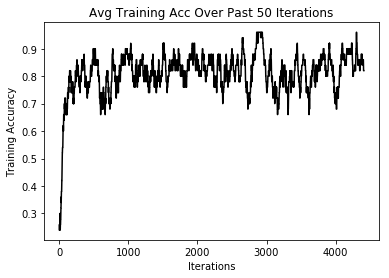

In [23]:
%matplotlib inline
# Plot training accuracy over time
plt.plot(range(len(train_acc_avg)), train_acc_avg, 'k-', label='Train Accuracy')
plt.title('Avg Training Acc Over Past 50 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Training Accuracy')
plt.show()

**限制句子（或文本）大小的原因值得在这里解释一下。在此示例中，我们将文本大小限制为25个单词。这是 "bag of words" 的常见做法，因为它限制了文本长度对预测的影响。你可以想象，如果我们找到一个单词，例如“会议 (meeting) ”，这可以预测文本是ham（而不是spam），那么垃圾邮件很可能会通过在邮件中多次输入该单词来避开垃圾邮件的检测。实际上，这是目标数据不平衡 (imbalanced target data) 的常见问题。在这种情况下很可能会出现不平衡的数据，因为垃圾邮件 (spam) 可能很难找到，而正常的邮件 (ham) 可能很容易找到。由于这个事实，我们创建的词表可能会严重偏向我们数据的ham部分所代表的单词（更多的 ham 意味着更多的单词在ham中表示而不是 spam ）。如果我们允许长度不限的文本，那么垃圾邮件制造者可能会利用这一点并创建非常长的文本，这些文本在我们的模型中触发正常邮件 word factors 的概率更高。**